In [535]:
from PBSHM_mdof.models.utils import compute_auc, plot_control_chart, plot_control_chart_latent , compute_auc_df


In [504]:

#%%
import tensorflow as tf
from datetime import datetime
from PBSHM_mdof.data.formatting import format_data
from PBSHM_mdof.models.classification.dense_nn import DenseSignalClassifier, get_loss

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import mlflow
import mlflow.keras
import pandas as pd
import seaborn as sns
from PBSHM_mdof.models.utils import compute_auc, plot_control_chart, plot_control_chart_latent , compute_auc_df

#%%
# Load and format the data
snr = None

def data_name_SNR(SNR=None):
    if SNR == None:
        data_name = 'no_noise.parquet'
    else:
        data_name = f'SNR_{SNR}.parquet'
    return data_name

data_name = data_name_SNR(snr)

df, labels, index_train, index_test, transformer = format_data(test_size=0.5,data_name=data_name)
psds_test = np.stack(df.loc[index_test]['psd'].values)
psds_train = np.stack(df.loc[index_train]['psd'].values)

system_id_test = labels[index_test]
system_id_train = labels[index_train]

num_class = system_id_train.shape[-1]
system_name = (df['system_name'].unique()).tolist()
system_name.sort(key=lambda x:x[-2:])

# Log variable values to MLflow
latent_std = np.around(df['latent_value'].std())
latent_mean = np.around(df['latent_value'].mean())
training_size = len(index_train/num_class)
heterogenity = 0
loss_function = 'categorical_crossentropy'
layers =[512, 256,128, 64, 32,20]
optimizer = 'adam'
dropout_rate = 0
model = "DenseSignalClassifier"
activation = 'ReLU'
batch_norm = True
l1_reg = 0.0001
# prepare dataframe for plotting
#%%
df['type']= 'test'
df.loc[index_train, 'type'] = 'train'
df_result = df[['system_name','anomaly_level','state','latent_value','type']]


# Start MLflow run
df_result['anomaly_level'] = df_result['anomaly_level'].astype('float')
df_result['type'][(df_result['anomaly_level'] ==0)& (df_result['type'] == 'test')]='validation'

df['anomaly_level'] = df['anomaly_level'].astype('float')
df['type'][(df['anomaly_level'] ==0)& (df['type'] == 'test')]='validation'


INFO:root:No NaN values in PSDs
INFO:root:Number of experiments in train set for system_9: 600
INFO:root:Number of experiments in train set for system_15: 600
INFO:root:Number of experiments in train set for system_18: 600
INFO:root:Number of experiments in train set for system_19: 600
INFO:root:Number of experiments in train set for system_17: 600
INFO:root:Number of experiments in train set for system_2: 600
INFO:root:Number of experiments in train set for system_8: 600
INFO:root:Number of experiments in train set for system_6: 600
INFO:root:Number of experiments in train set for system_1: 600
INFO:root:Number of experiments in train set for system_11: 600
INFO:root:Number of experiments in train set for system_12: 600
INFO:root:Number of experiments in train set for system_7: 600
INFO:root:Number of experiments in train set for system_16: 600
INFO:root:Number of experiments in train set for system_13: 600
INFO:root:Number of experiments in train set for system_4: 600
INFO:root:Numbe

In [468]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 14

In [469]:
model_ = eval(model)(inputDim=(psds_train[0].shape[-1]),
                                num_class=system_id_train.shape[-1],
                                dense_layers=layers,
                                dropout_rate=dropout_rate,
                                batch_norm=batch_norm,
                                activation=activation,
                                l1_reg=l1_reg
                                )

In [470]:
model_=model_.build_model(optimizer=optimizer)


In [471]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="best_model.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                    factor=0.5, 
                                                    patience=5, 
                                                    min_lr=1e-6)

In [472]:
model_.fit(psds_train, system_id_train, epochs=100, batch_size=64,verbose=1,validation_split=0.2,
              callbacks=[early_stopping_callback,reduce_lr,model_checkpoint_callback])
best_model = tf.keras.models.load_model('best_model.h5',
                                             custom_objects={'DenseSignalClassifier': DenseSignalClassifier, 
                                                             'loss_fn': get_loss(temperature=1)})

Epoch 1/100
143/150 [===========================>..] - ETA: 0s - loss: 6.1991 - accuracy: 0.8122
Epoch 1: val_loss improved from inf to 3.80634, saving model to best_model.h5
150/150 [==============================] - 3s 9ms/step - loss: 6.0522 - accuracy: 0.8201 - val_loss: 3.8063 - val_accuracy: 0.0496 - lr: 0.0010
Epoch 2/100
147/150 [============================>.] - ETA: 0s - loss: 2.6173 - accuracy: 0.9771
Epoch 2: val_loss improved from 3.80634 to 3.27807, saving model to best_model.h5
150/150 [==============================] - 1s 8ms/step - loss: 2.6136 - accuracy: 0.9771 - val_loss: 3.2781 - val_accuracy: 0.0512 - lr: 0.0010
Epoch 3/100
146/150 [============================>.] - ETA: 0s - loss: 2.3356 - accuracy: 0.9799
Epoch 3: val_loss improved from 3.27807 to 3.14454, saving model to best_model.h5
150/150 [==============================] - 1s 8ms/step - loss: 2.3344 - accuracy: 0.9796 - val_loss: 3.1445 - val_accuracy: 0.0954 - lr: 0.0010
Epoch 4/100
145/150 [==============

In [625]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [641]:
score = best_model.predict(np.stack(df['psd'].values))
true_class = np.argmax(labels, axis=1)
predicted_class = np.argmax(score, axis=1)
confidence=score[np.arange(len(true_class)), true_class]

1625/1625 [==============================] - 2s 1ms/step


In [642]:
df_result['confidence'] = confidence

/tmp/ipykernel_138622/1541609246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['confidence'] = confidence


In [643]:
df_result['type'].value_counts()

test          28000
train         12000
validation    12000
Name: type, dtype: int64

In [644]:
np.sum((df_result['type']=='validation') & (df_result['system_name']=='system_12'))

600

In [645]:
compute_auc_df(df_result,col_name='confidence')

,system_0,system_1,system_2,system_3,system_4,system_5,system_6,system_7,system_8,system_9,system_10,system_11,system_12,system_13,system_14,system_15,system_16,system_17,system_18,system_19
auc_0.0,0.498088,0.523743,0.515885,0.503537,0.481494,0.516556,0.508843,0.508514,0.541839,0.480042,0.499144,0.517307,0.500924,0.501289,0.514279,0.491617,0.498086,0.497281,0.504944,0.479539
auc_0.01,0.558588,0.391988,0.538887,0.632862,0.60065,0.702887,0.56935,0.460562,0.437975,0.505862,0.559975,0.621637,0.550838,0.458238,0.59,0.6967,0.525837,0.602225,0.551313,0.616013
auc_0.03,0.62015,0.295813,0.693975,0.904025,0.754875,0.921813,0.669787,0.508063,0.392413,0.504775,0.878825,0.868113,0.730225,0.339388,0.791237,0.916775,0.682275,0.746088,0.64835,0.7908
auc_0.05,0.783375,0.267363,0.910112,0.9666,0.87945,0.9819,0.844738,0.874325,0.3819,0.716588,0.985687,0.969588,0.903925,0.286738,0.96605,0.982287,0.93715,0.864362,0.792875,0.977412
auc_0.07,0.953375,0.268962,0.978525,0.9932,0.95415,0.995425,0.970813,0.99825,0.375525,0.9167,0.997375,0.9912,0.9836,0.344625,0.99625,1.0,0.991913,0.963925,0.889112,0.9984
auc_0.09,0.993987,0.335925,0.99715,0.998125,0.984175,0.99935,0.993525,1.0,0.4961,0.99725,1.0,0.99985,0.99415,0.371425,0.99955,1.0,0.99995,0.991375,0.9622,0.999975
auc_0.11,0.998925,0.4938,0.999675,0.999625,0.99645,0.99995,0.99975,1.0,0.58565,1.0,1.0,1.0,0.99675,0.385975,1.0,1.0,1.0,0.9999,0.988225,1.0
auc_0.13,0.99995,0.655062,1.0,1.0,0.999475,1.0,1.0,1.0,0.756687,1.0,1.0,1.0,0.99805,0.417275,1.0,1.0,1.0,1.0,0.99655,1.0


In [648]:
psds_validation = np.stack(df.loc[df['type']=='validation']['psd'].values)
embedding=best_model.layers[1].call_encoder(psds_validation)

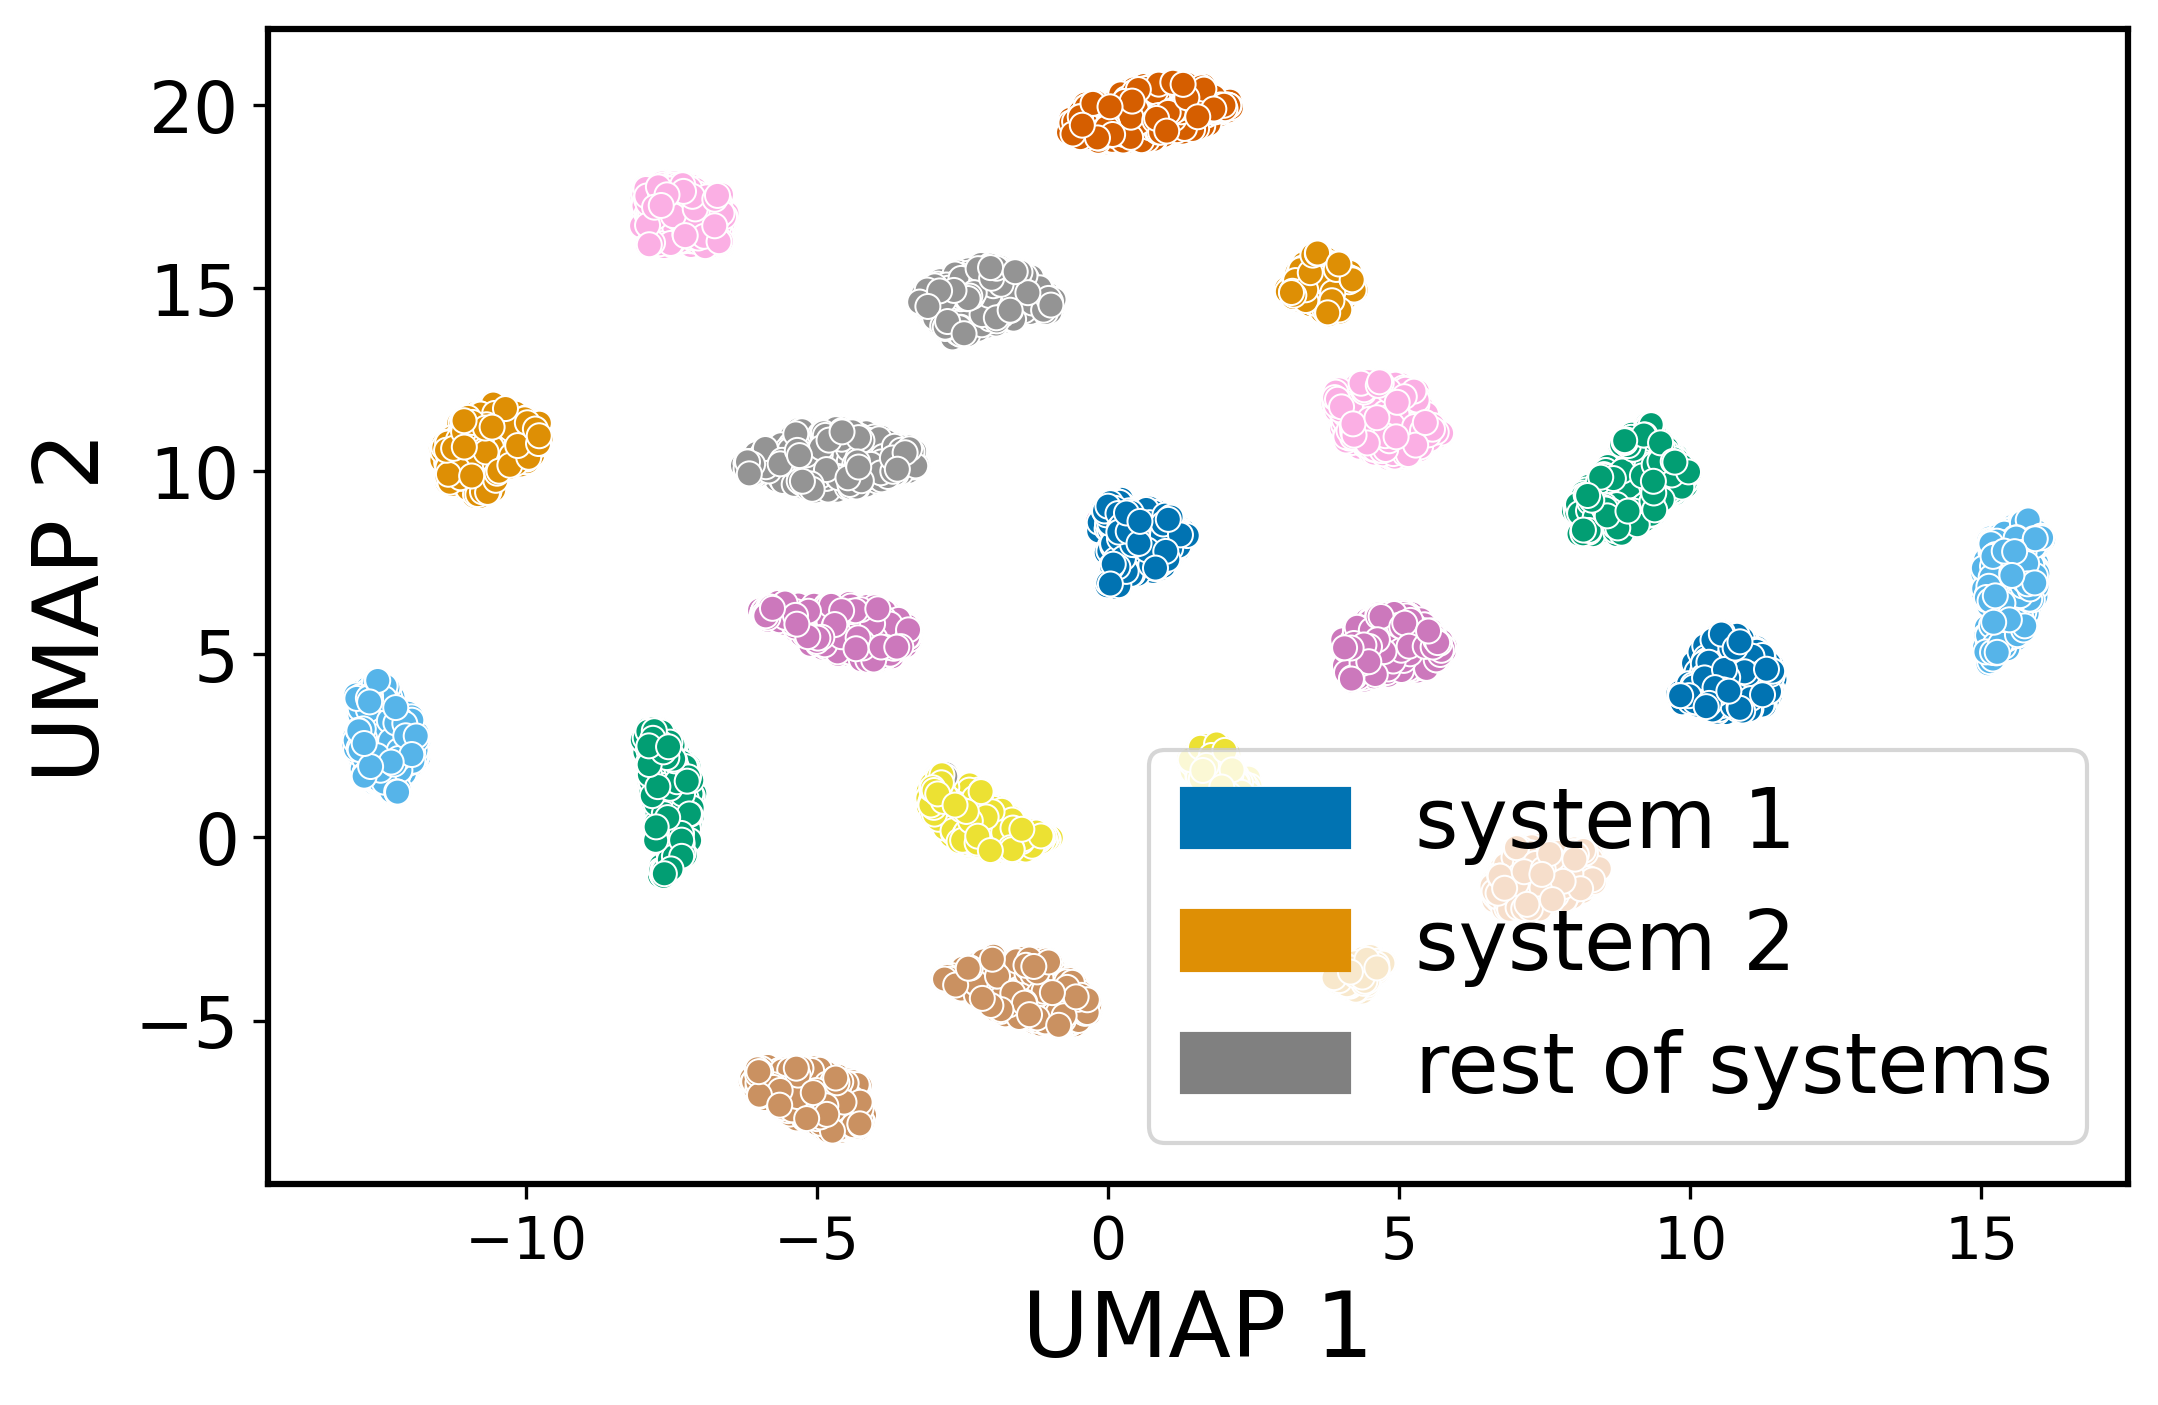

In [649]:
# Using UMAP to visualize the latent space
import umap
reducer = umap.UMAP()
embedding_emb = reducer.fit_transform(embedding)

import seaborn as sns
cm = sns.color_palette('colorblind', n_colors=20)

# Create a custom legend for the first two colors
legend_dict = {'system 1': cm[0], 'system 2': cm[1], 'rest of systems': 'gray'}

# Add a third line to the legend indicating the number of additional systems


fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=embedding_emb[:,0], y=embedding_emb[:,1], hue=df.loc[df['type']=='validation']['system_name'], palette=cm, ax=ax)

# Add the custom legend to the plot
ax.legend(handles=[plt.Rectangle((0,0),1,1, color=val) for key, val in legend_dict.items()], labels=legend_dict.keys(), fontsize=20,loc='lower right')

ax.set_xlabel('UMAP 1', fontsize=22)
ax.set_ylabel('UMAP 2', fontsize=22)
fig.savefig('../docs/umap1.png', dpi=300, bbox_inches='tight')


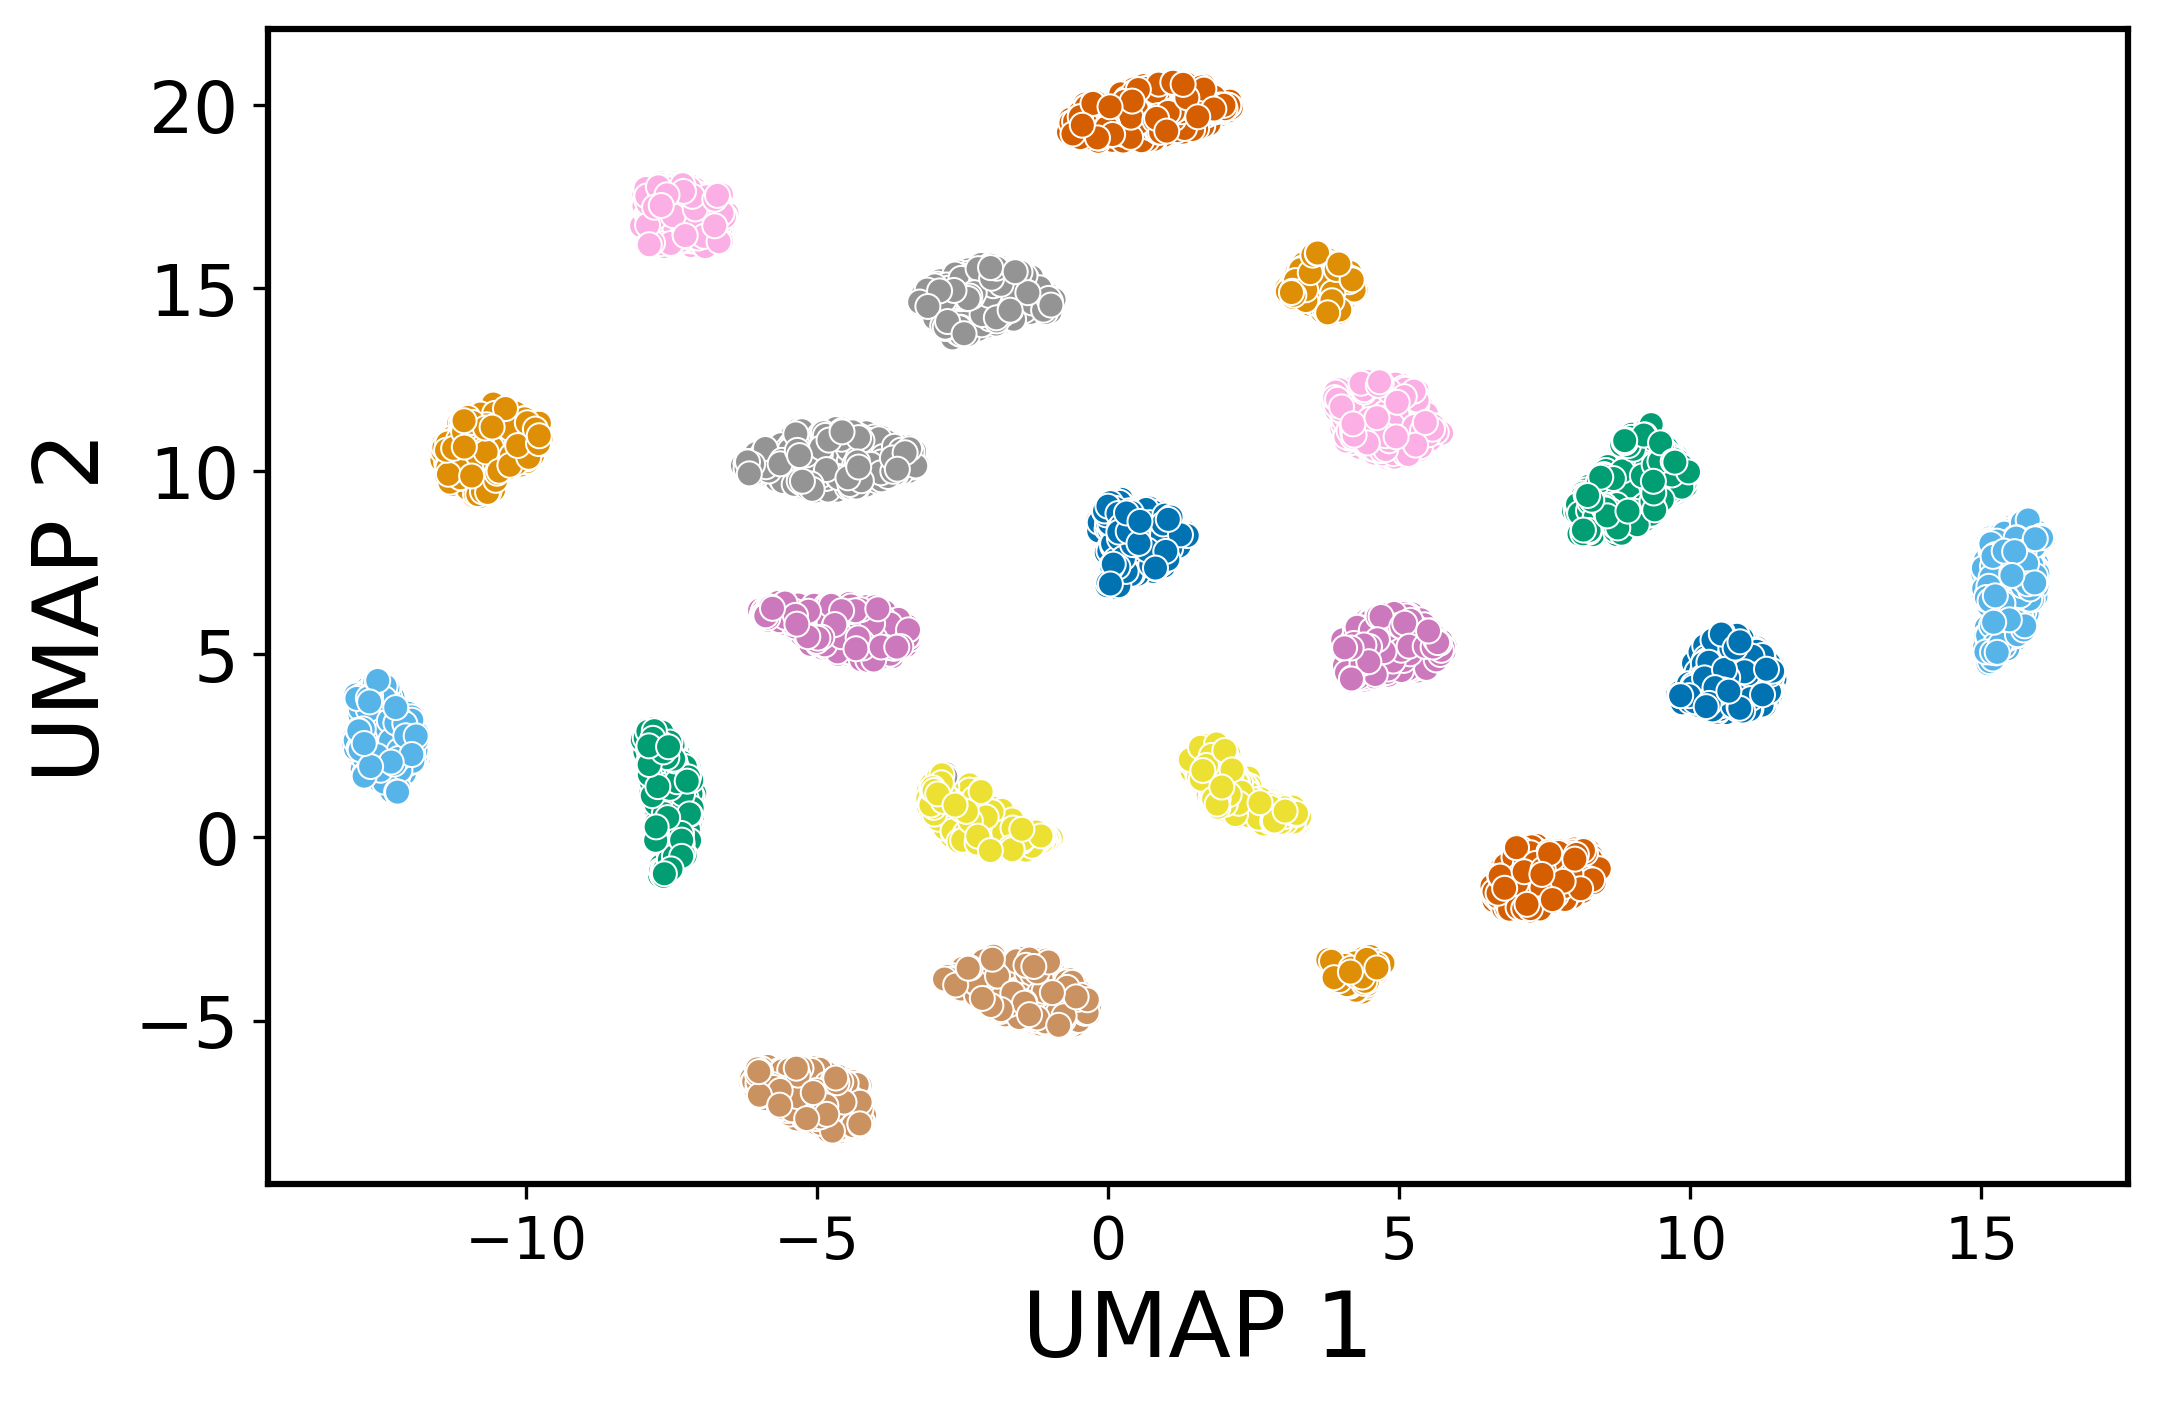

In [650]:
import seaborn as sns
cm = sns.color_palette('colorblind', n_colors=20)

# Create a custom legend for the first two colors
legend_dict = {'system 1': cm[0], 'system 2': cm[1], 'rest of systems': 'gray'}

# Add a third line to the legend indicating the number of additional systems


fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=embedding_emb[:,0], y=embedding_emb[:,1], hue=df.loc[df['type']=='validation']['system_name'], palette=cm, ax=ax)

# Add the custom legend to the plot
ax.legend(handles=[plt.Rectangle((0,0),1,1, color=val) for key, val in legend_dict.items()], labels=legend_dict.keys(), fontsize=20,loc='lower right')
ax.get_legend().remove()
ax.set_xlabel('UMAP 1', fontsize=22)
ax.set_ylabel('UMAP 2', fontsize=22)
fig.savefig('../docs/umap1.png', dpi=300, bbox_inches='tight')

In [651]:
# visualize the latent space using pca 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embedding)


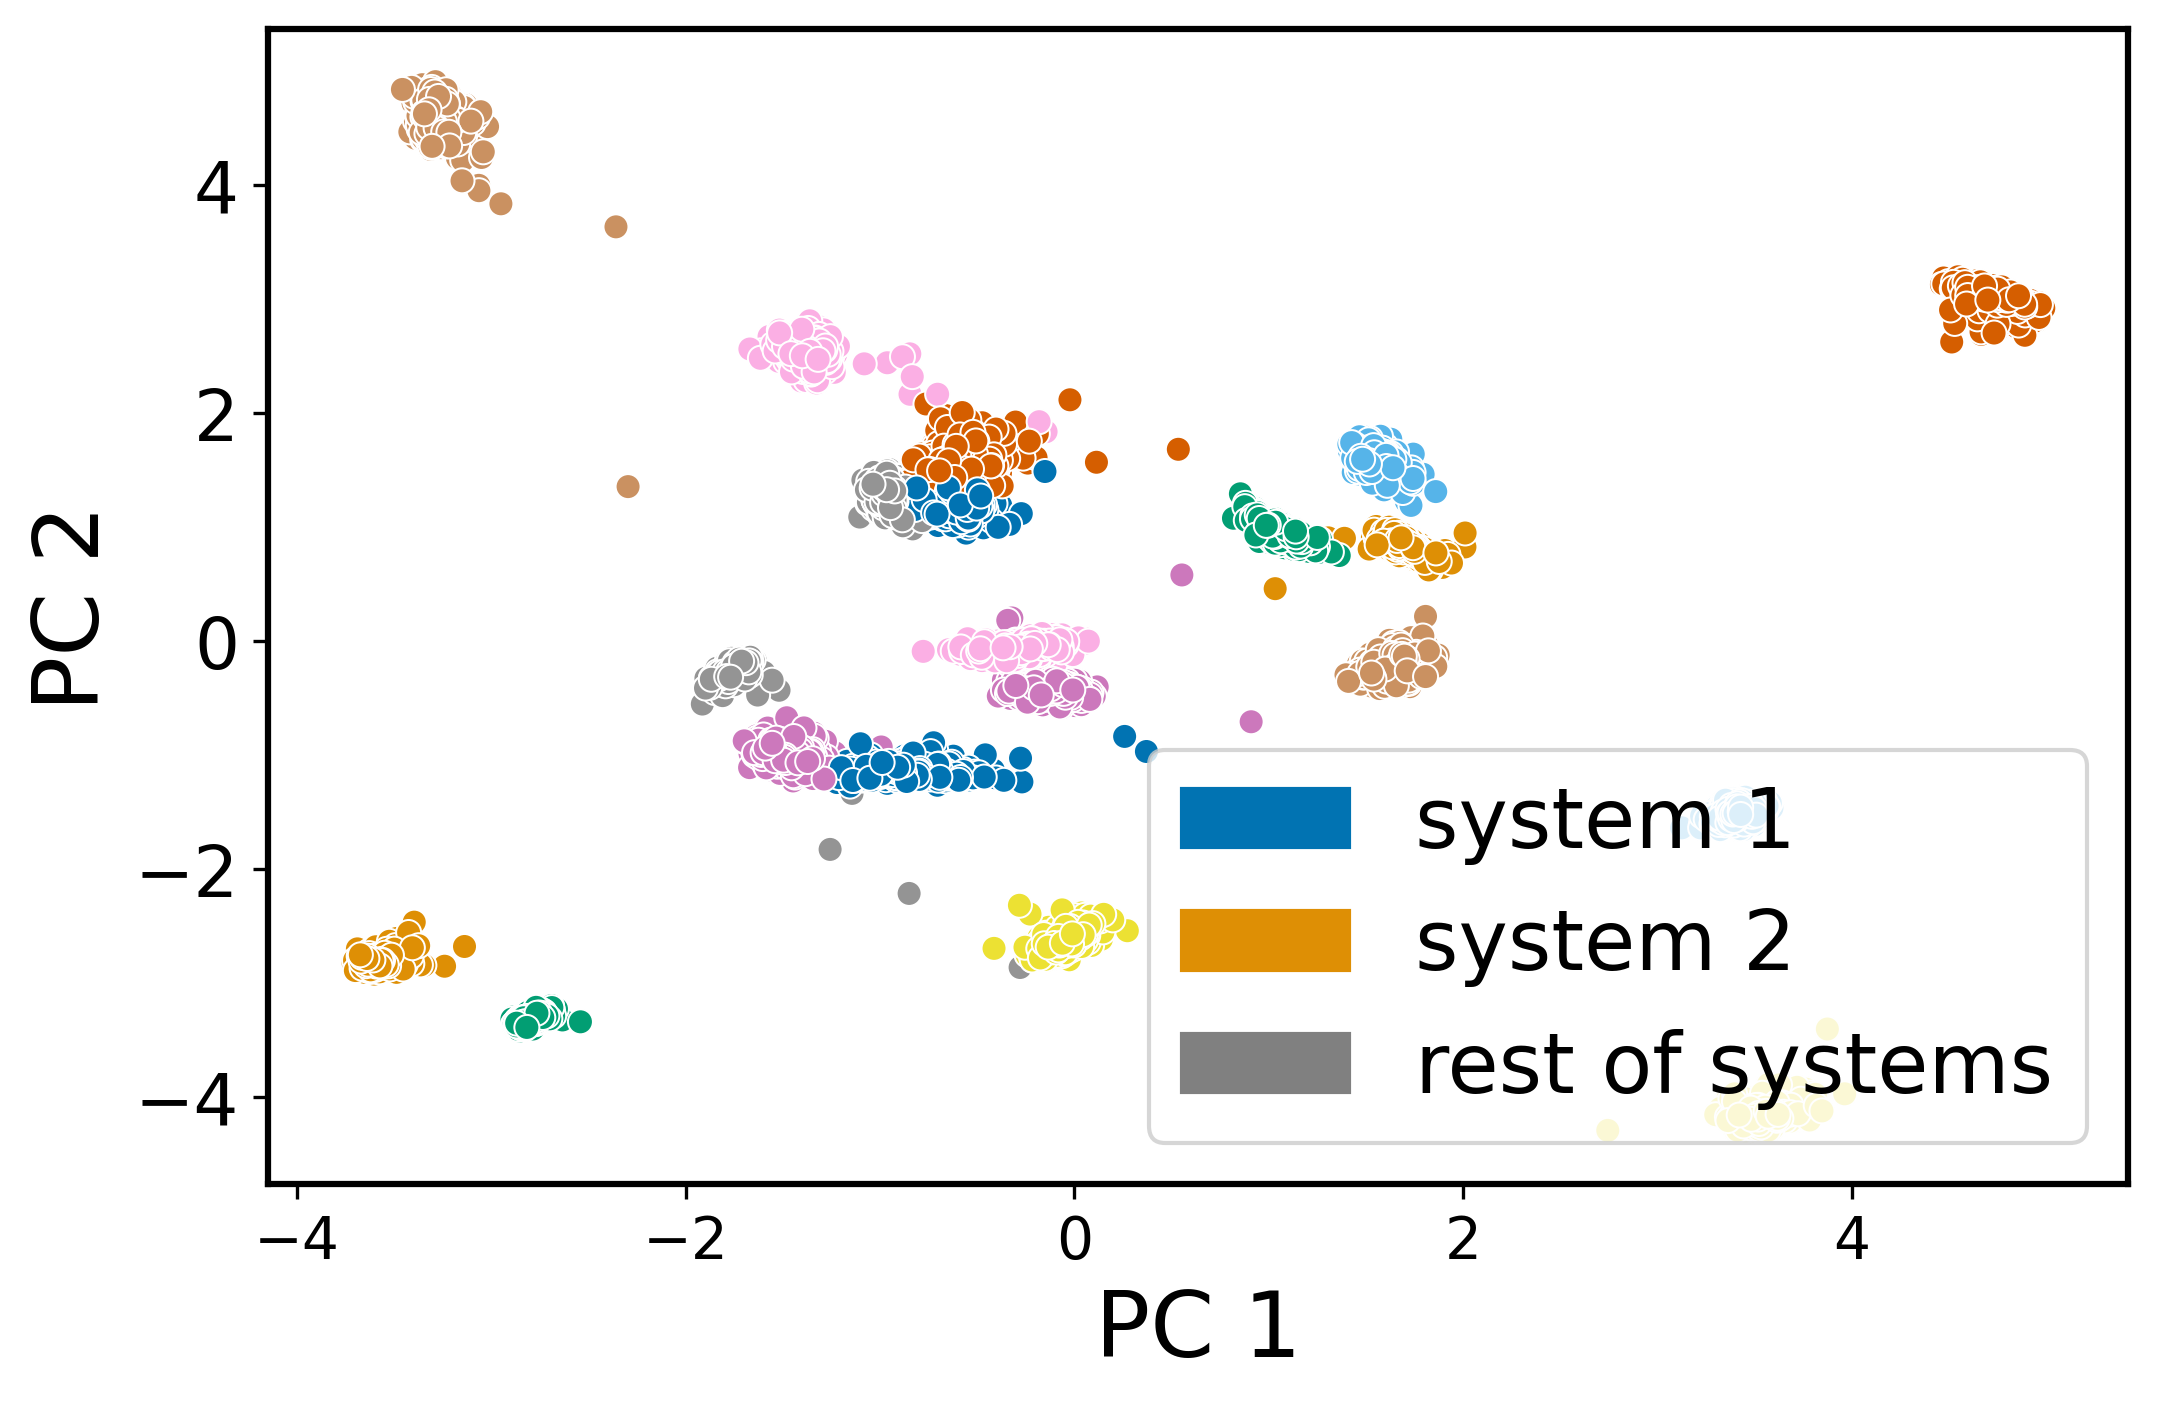

In [652]:
import seaborn as sns
cm = sns.color_palette('colorblind', n_colors=20)

# Create a custom legend for the first two colors
legend_dict = {'system 1': cm[0], 'system 2': cm[1], 'rest of systems': 'gray'}

# Add a third line to the legend indicating the number of additional systems


fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=embedding_pca[:,0], y=embedding_pca[:,1], hue=df.loc[df['type']=='validation']['system_name'], palette=cm, ax=ax)

# Add the custom legend to the plot
ax.legend(handles=[plt.Rectangle((0,0),1,1, color=val) for key, val in legend_dict.items()], labels=legend_dict.keys(), fontsize=20,loc='lower right')

ax.set_xlabel('PC 1', fontsize=22)
ax.set_ylabel('PC 2', fontsize=22)
fig.savefig('../docs/pca.png', dpi=300, bbox_inches='tight')

In [655]:
#fit a gaussian mixture model to the data
from sklearn.mixture import GaussianMixture
psd_train = np.stack(df.loc[df['type']=='train']['psd'].values)
embedding=best_model.layers[1].call_encoder_penultimate(psd_train)
gmm = GaussianMixture(n_components=2).fit(embedding)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f84b38ca290>
Traceback (most recent call last):
  File "/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/yacine/miniconda3/envs/PBSHM_mdofenv/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [656]:
psd_all = np.stack(df['psd'].values)
model__= best_model.layers[1]
#pen,
embedding_all=best_model.layers[1].call_encoder_penultimate(psd_all)
score = gmm.score_samples(embedding_all)

In [657]:
embedding_all

<tf.Tensor: shape=(52000, 32), dtype=float32, numpy=
array([[ 0.01783946,  0.9082976 , -0.31209177, ..., -0.58293736,
         0.6127892 , -0.19965875],
       [ 0.01783946, -0.17939512, -1.0244517 , ..., -0.58293736,
        -0.7457083 , -0.19965875],
       [ 0.01783946, -0.17939512,  0.95663   , ..., -0.58293736,
        -0.7457083 ,  1.3710237 ],
       ...,
       [ 0.01783946, -0.17939512, -0.29857302, ..., -0.58293736,
         1.3233342 , -0.19965875],
       [ 0.01783946, -0.17939512, -0.22481853, ...,  0.20157123,
        -0.46713334, -0.19965875],
       [ 0.01783946, -0.17939512,  0.85033405, ...,  1.4722072 ,
        -0.7457083 , -0.19965875]], dtype=float32)>

In [658]:
df_result['gmm-score'] = score

/tmp/ipykernel_138622/697320535.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['gmm-score'] = score


In [659]:
df_result['gmm-score'] = df_result['gmm-score'] - df_result['gmm-score'].min()

/tmp/ipykernel_138622/3048352814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['gmm-score'] = df_result['gmm-score'] - df_result['gmm-score'].min()


In [660]:
def compute_auc_df(df,col_name='confidence'):
    system_name = df['system_name'].unique().tolist()
    system_name.sort(key=lambda x: int(x.split('_')[-1]))
    anomaly_level = np.sort(df['anomaly_level'].unique())
    auc_df = pd.DataFrame(columns=system_name)
    for system_id in system_name:
        healthy_training_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'train')]
        healthy_testing_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'validation')]
      
        
        for al in anomaly_level:
            if al == 0:
                assert len(healthy_training_data) == len(healthy_testing_data)
                auc = compute_auc(healthy_training_data, healthy_testing_data)
            else:
                anomaly_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'test') & (df['anomaly_level'] == al)]
                healthy_testing_data = df[col_name][(df['system_name'] == system_id) & (df['type'] == 'validation')].iloc[-len(anomaly_data):]
                assert len(anomaly_data) == len(healthy_testing_data)
                auc = compute_auc(healthy_testing_data, anomaly_data)
            auc_df.loc[f'auc_{al}', system_id] = auc
    return auc_df

In [661]:
compute_auc_df(df_result,col_name='gmm-score').mean(axis=1)


auc_0.0     0.504192
auc_0.01    0.559486
auc_0.03    0.792137
auc_0.05    0.935056
auc_0.07    0.974002
auc_0.09    0.985133
auc_0.11    0.992096
auc_0.13    0.996073
dtype: float64

In [662]:
col_name = 'gmm-score'
system_id = 'system_1'
healthy_testing_data = df_result[col_name][(df_result['system_name'] == system_id) & (df_result['type'] == 'validation')]


In [663]:
((df_result['system_name'] == system_id)  & (df_result['type'] == 'validation')).sum()

600

In [664]:
# count proportions of types of data
df_result['type'].value_counts()

test          28000
train         12000
validation    12000
Name: type, dtype: int64

In [665]:
df_result

,system_name,anomaly_level,state,latent_value,type,gmm-score,confidence
0,system_0,0.01,anomalous,26.871220,test,5847.760014,0.125115
1,system_1,0.01,anomalous,26.871220,test,5835.415552,0.125111
2,system_10,0.01,anomalous,26.871220,test,5834.491130,0.125127
3,system_11,0.01,anomalous,26.871220,test,5850.339131,0.125098
4,system_12,0.01,anomalous,26.871220,test,5840.445204,0.125129
...,...,...,...,...,...,...,...
51995,system_5,0.00,healthy,80.960747,train,5838.767563,0.125092
51996,system_6,0.00,healthy,80.960747,train,5835.916803,0.125115
51997,system_7,0.00,healthy,80.960747,validation,5850.176708,0.125113
51998,system_8,0.00,healthy,80.960747,validation,5816.572112,0.125118


In [666]:
df_result['gmm-score'] = df_result['gmm-score'] + 0.5

/tmp/ipykernel_138622/4011517232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['gmm-score'] = df_result['gmm-score'] + 0.5


In [667]:
# min max scale the gmm score
df_result['gmm-score'] = (df_result['gmm-score'] - 0.5)/(1.1 - 0.5)

/tmp/ipykernel_138622/2363160882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['gmm-score'] = (df_result['gmm-score'] - 0.5)/(1.1 - 0.5)


In [668]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [681]:
def plot_control_chart(df,system_id, column='confidence', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    data_system = df[df['system_name'] == system_id]
    df_train = data_system[data_system['type'] == 'train']
    df_test = data_system[data_system['type'] == 'test']
    df_test= df_test.sort_values(by='anomaly_level', ascending=True)

    df_plot = pd.concat([df_train, df_test])
    df_plot.reset_index(inplace=True)
    #df_plot[column]=df_plot[column].rolling(10).apply(lambda x:np.prod(x))
    ax.plot(df_plot.index, df_plot[column], marker='.', linestyle='')
    anomaly_level=df_plot[df_plot['anomaly_level'].astype(float).diff()!=0]['anomaly_level'].to_dict()

    y_lowbound, y_upbound= ax.get_ylim()
    middle = (y_lowbound + y_upbound) / 2
    range = (y_upbound - y_lowbound) / 2
    text_y = middle - range * 0.9


    ax.axvline(x=len(df_train), color='firebrick', linestyle='--', alpha=0.5)
    #ax.text(len(df_train), text_y, 'test data', rotation=90, color='firebrick', alpha=0.9)
    for key in list(anomaly_level.keys())[1:]:
        ax.axvline(x=key, color='firebrick', linestyle='--', alpha=0.5)
        ax.text(key, text_y, anomaly_level[key], color='black', alpha=1,rotation=90)

    mean = np.mean(df_plot.iloc[:len(df_train)][column])
    std = np.std(df_plot.iloc[:len(df_train)][column])
    lcl = mean - 2 * std
    ax.plot()
    ax.axhline(y=lcl, color='firebrick', linestyle='--', alpha=0.5)
    ax.text(0, lcl-0.2*range, 'LCL', rotation=0, color='firebrick', alpha=0.9)
    # coloring out of control data with red 
    allert_df = df_plot[df_plot[column] < lcl]
    ax.plot(allert_df.index, allert_df[column], marker='.', linestyle='', color='red')

    ax.set_ylabel(column)
    ax.set_xlabel('index')
    ax.set_title(system_id)
    return  ax


In [682]:
sys = 'system_17'
df_sys = df_result[df_result['system_name'] == sys]
min = df_sys['gmm-score'].min()
max = df_sys['gmm-score'].max()
df_result['gmm-score'] = (df_result['gmm-score'] - min)/(max - min)

/tmp/ipykernel_138622/2741138174.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['gmm-score'] = (df_result['gmm-score'] - min)/(max - min)


In [683]:
df_result['gmm-score']

0        1.001611
1        0.996643
2        0.996271
3        1.002648
4        0.998667
           ...   
51995    0.997992
51996    0.996845
51997    1.002583
51998    0.989061
51999    0.995218
Name: gmm-score, Length: 52000, dtype: float64

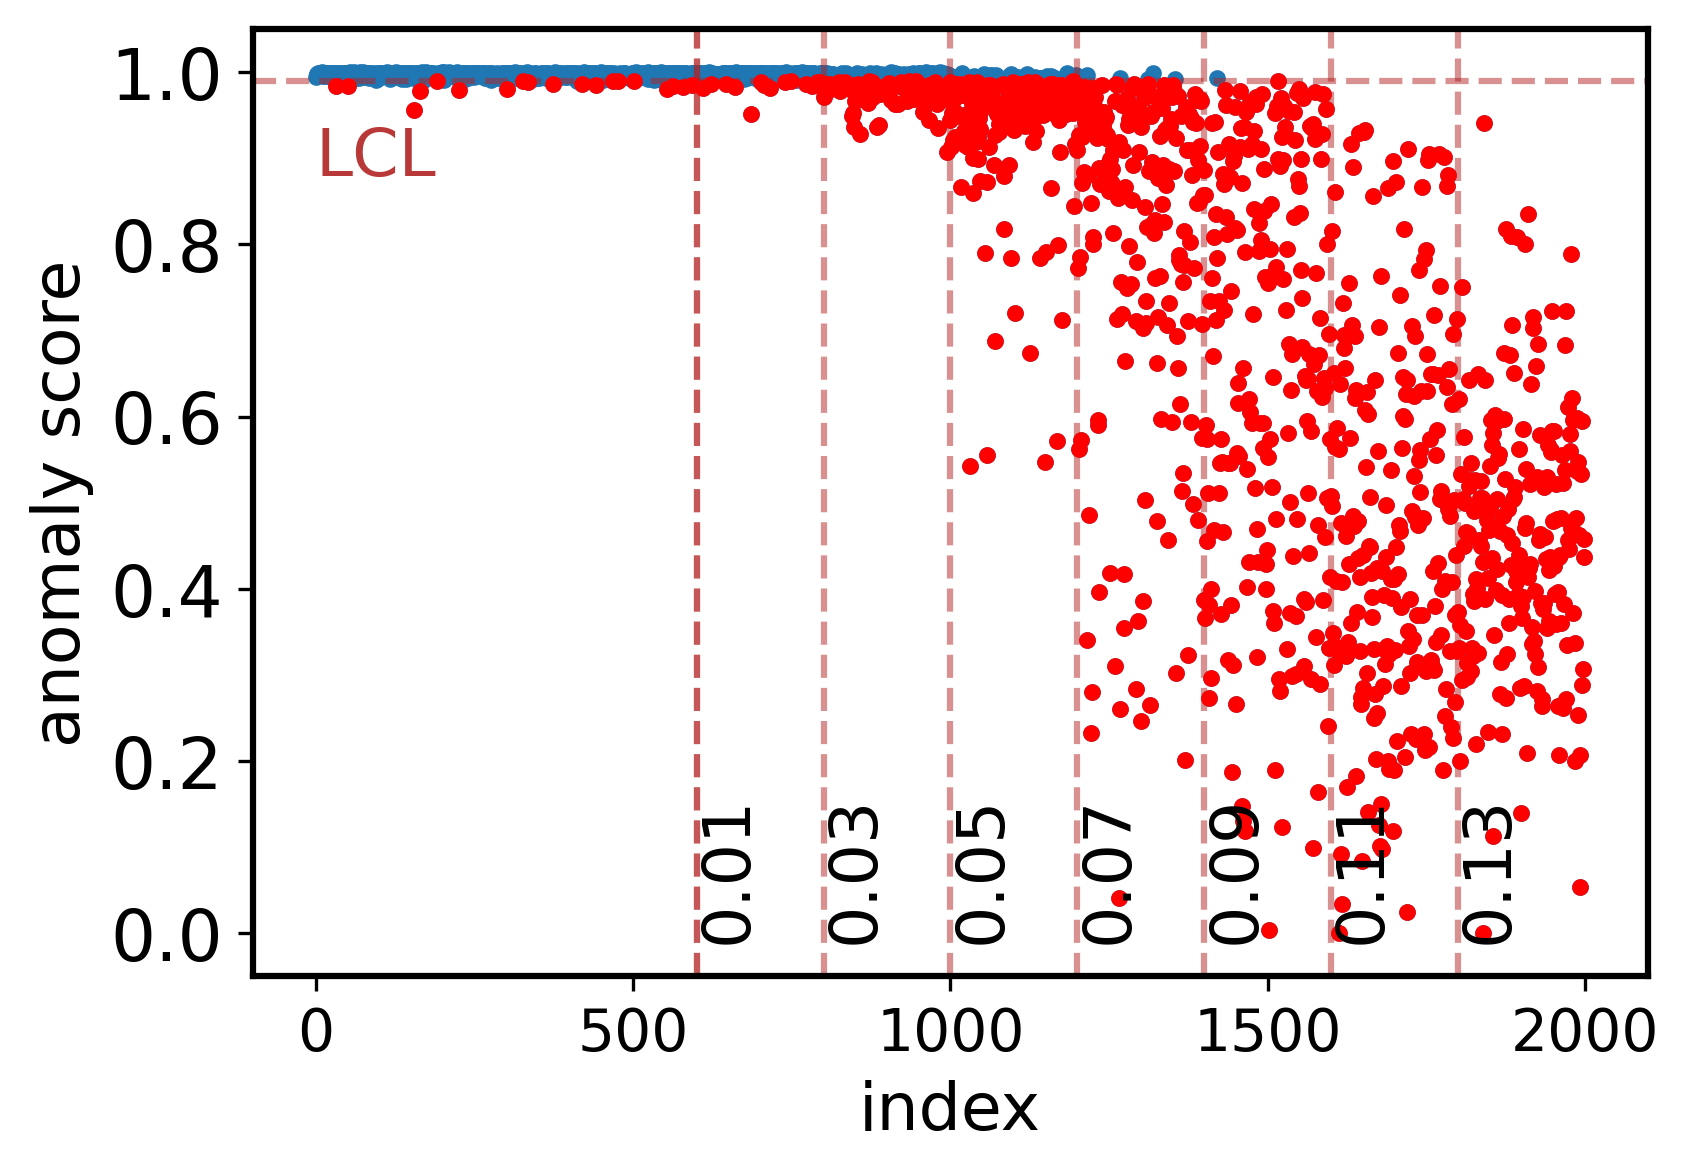

In [684]:
fig,ax= plt.subplots(figsize=(6, 4.1))
plot_control_chart(df_result,column='gmm-score',system_id='system_17',ax=ax)
plt.ylabel('anomaly score')
plt.title(label='')
fig.savefig('gmm_score_system_1.png',dpi=300,bbox_inches='tight')


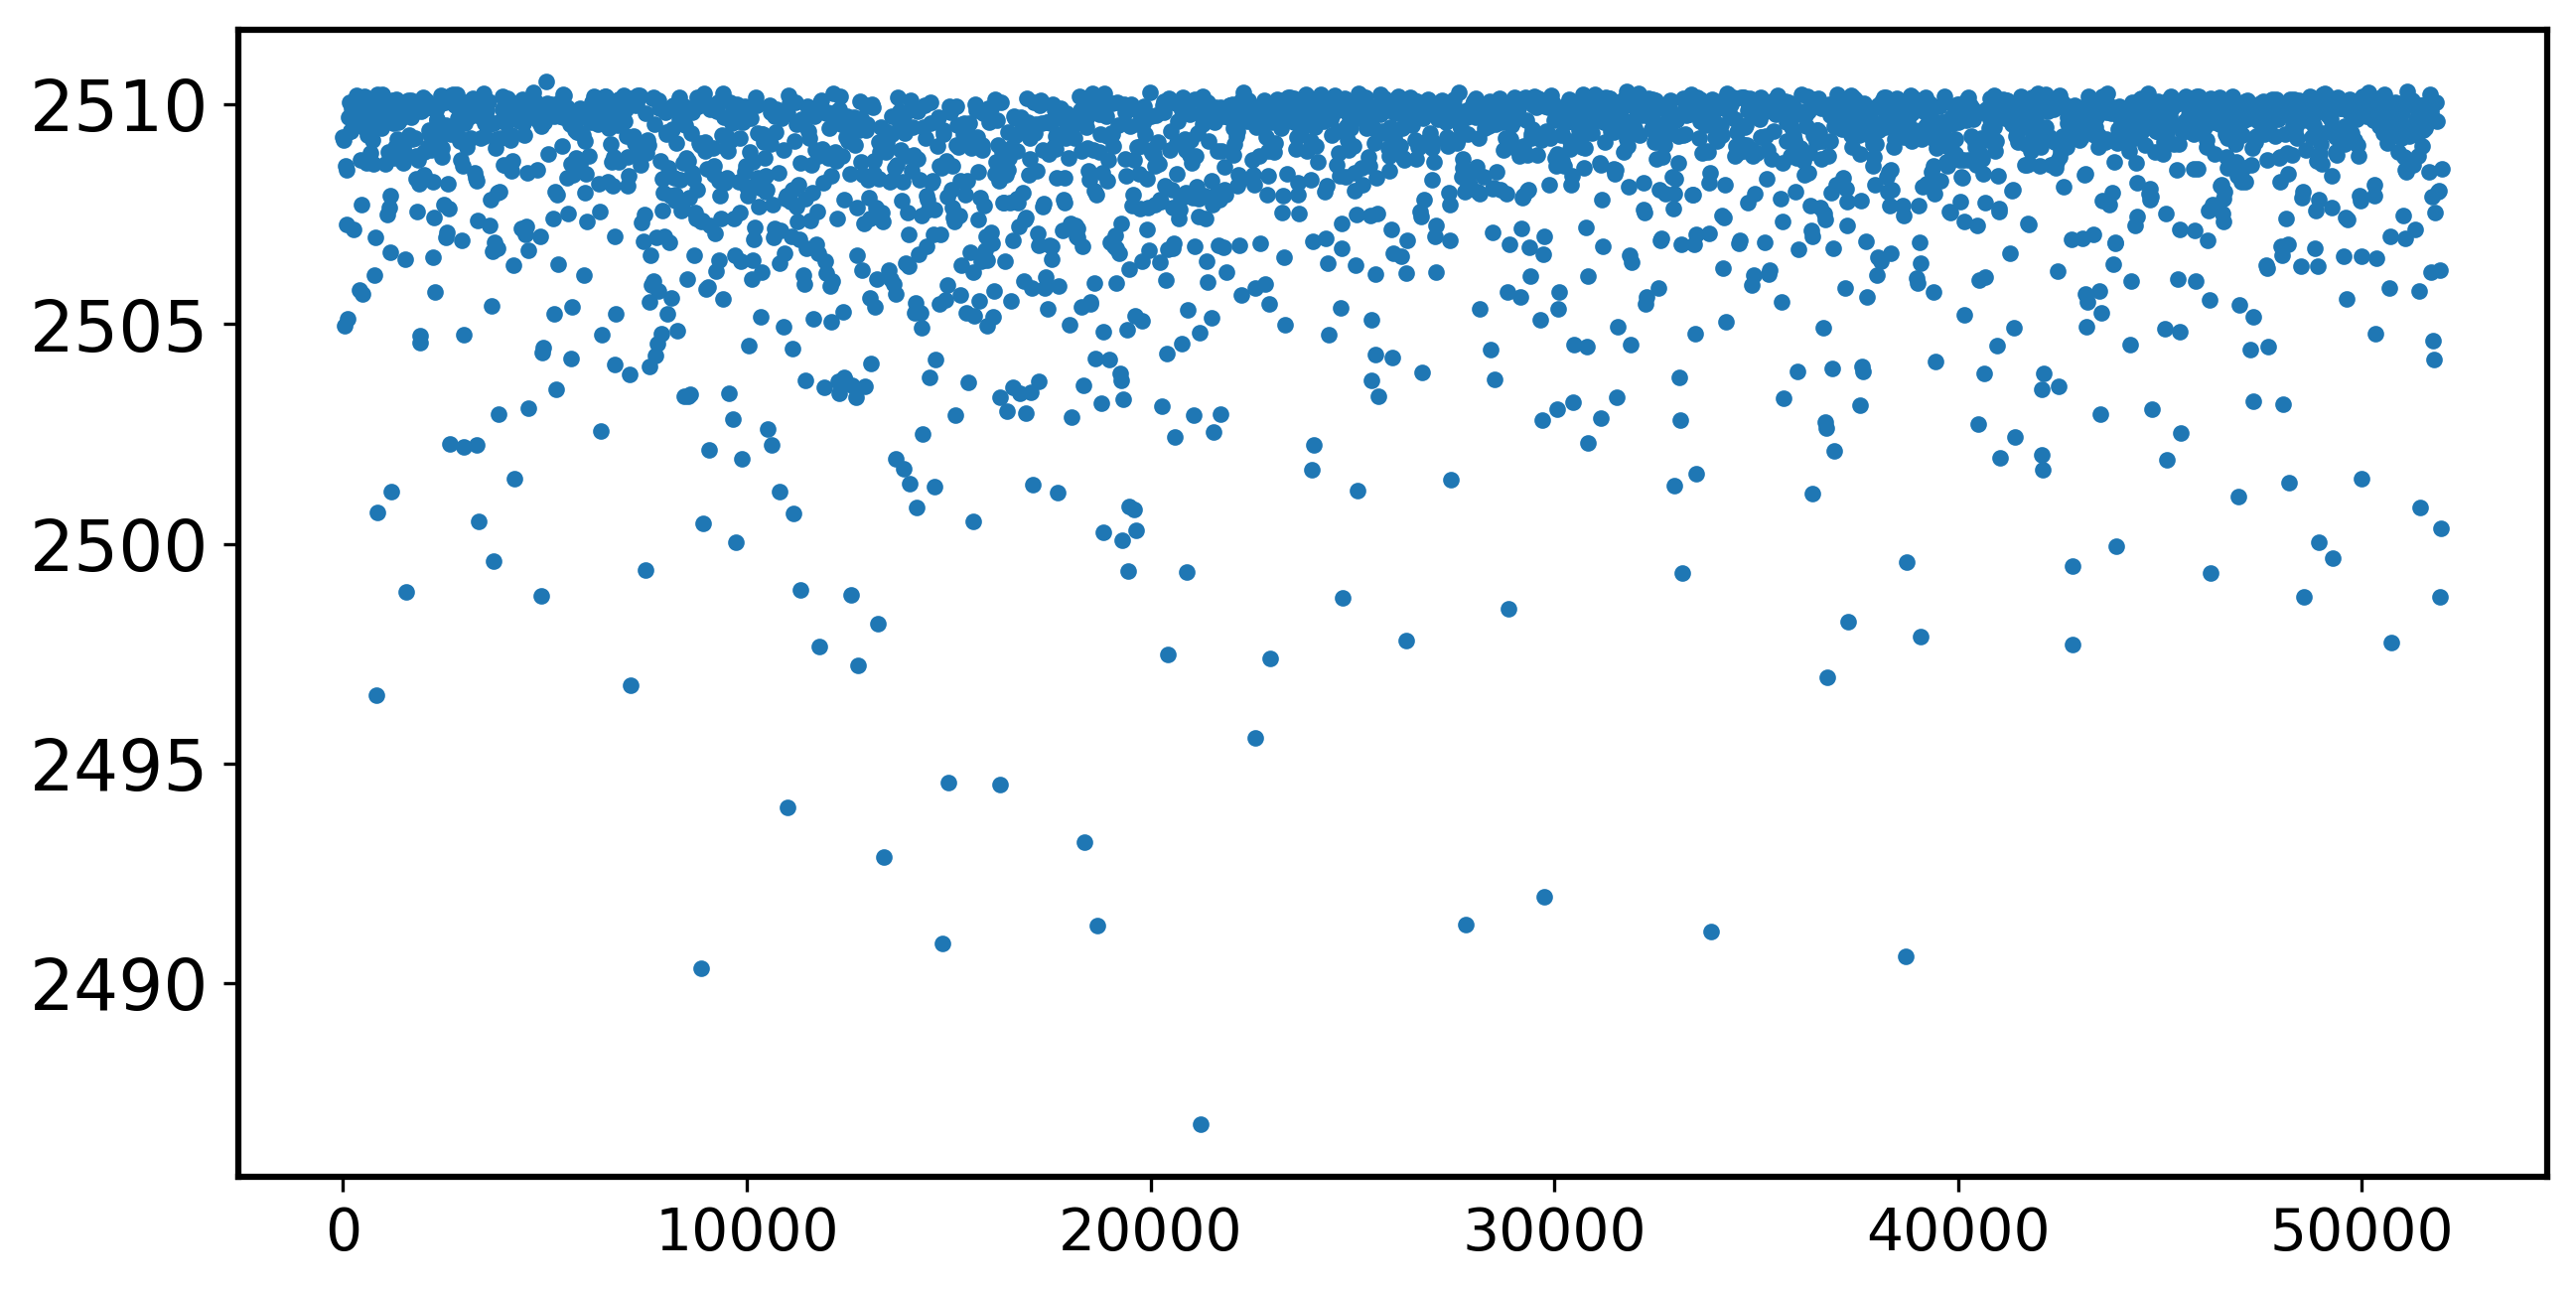

In [353]:
def arrange_control_chart_data(df, system_id, column='confidence'):
    data_system = df[df['system_name'] == system_id]
    df_train = data_system[data_system['type'] == 'train']
    df_test = data_system[data_system['type'] == 'test']
    df_test = df_test.sort_values(by='anomaly_level', ascending=True)
    df_plot = pd.concat([df_train, df_test])
    df_plot.reset_index(inplace=True)
    return df_plot, df_train, len(df_train)


In [360]:
df_plot,df_train,train_len = arrange_control_chart_data(df_result,system_id='system_10',column='gmm-score')

In [361]:
#normalize the data
df_plot['gmm-score'] = (df_plot['gmm-score'] - df_plot['gmm-score'].min())/(df_plot['gmm-score'].max()-df_plot['gmm-score'].min())

In [362]:
def plot_control_chart(df_plot, df_train, train_len, column='confidence', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        
    ax.plot(df_plot.index, df_plot[column], marker='.', linestyle='')

    anomaly_level = df_plot[df_plot['anomaly_level'].astype(float).diff()!=0]['anomaly_level'].to_dict()
    y_lowbound, y_upbound= ax.get_ylim()
    middle = (y_lowbound + y_upbound) / 2
    range = (y_upbound - y_lowbound) / 2
    text_y = middle - range * 0.1

    ax.axvline(x=train_len, color='firebrick', linestyle='--', alpha=0.5)
    ax.text(train_len, text_y, 'test data', rotation=90, color='firebrick', alpha=0.9)

    for key in list(anomaly_level.keys())[1:]:
        ax.axvline(x=key, color='firebrick', linestyle='--', alpha=0.5)
        ax.text(key, text_y, anomaly_level[key], color='black', alpha=1,rotation=90)

    mean = np.mean(df_train[column])
    std = np.std(df_train[column])
    lcl = mean - 2 * std
    ax.plot()
    ax.axhline(y=lcl, color='firebrick', linestyle='--', alpha=0.5)
    ax.text(0, lcl-0.1*range, 'LCL', rotation=0, color='firebrick', alpha=0.9)

    allert_df = df_plot[df_plot[column] < lcl]
    ax.plot(allert_df.index, allert_df[column], marker='.', linestyle='', color='red')

    ax.set_ylabel(column)
    ax.set_xlabel('index')
    ax.set_title(system_id)

    return fig, ax


<AxesSubplot: >

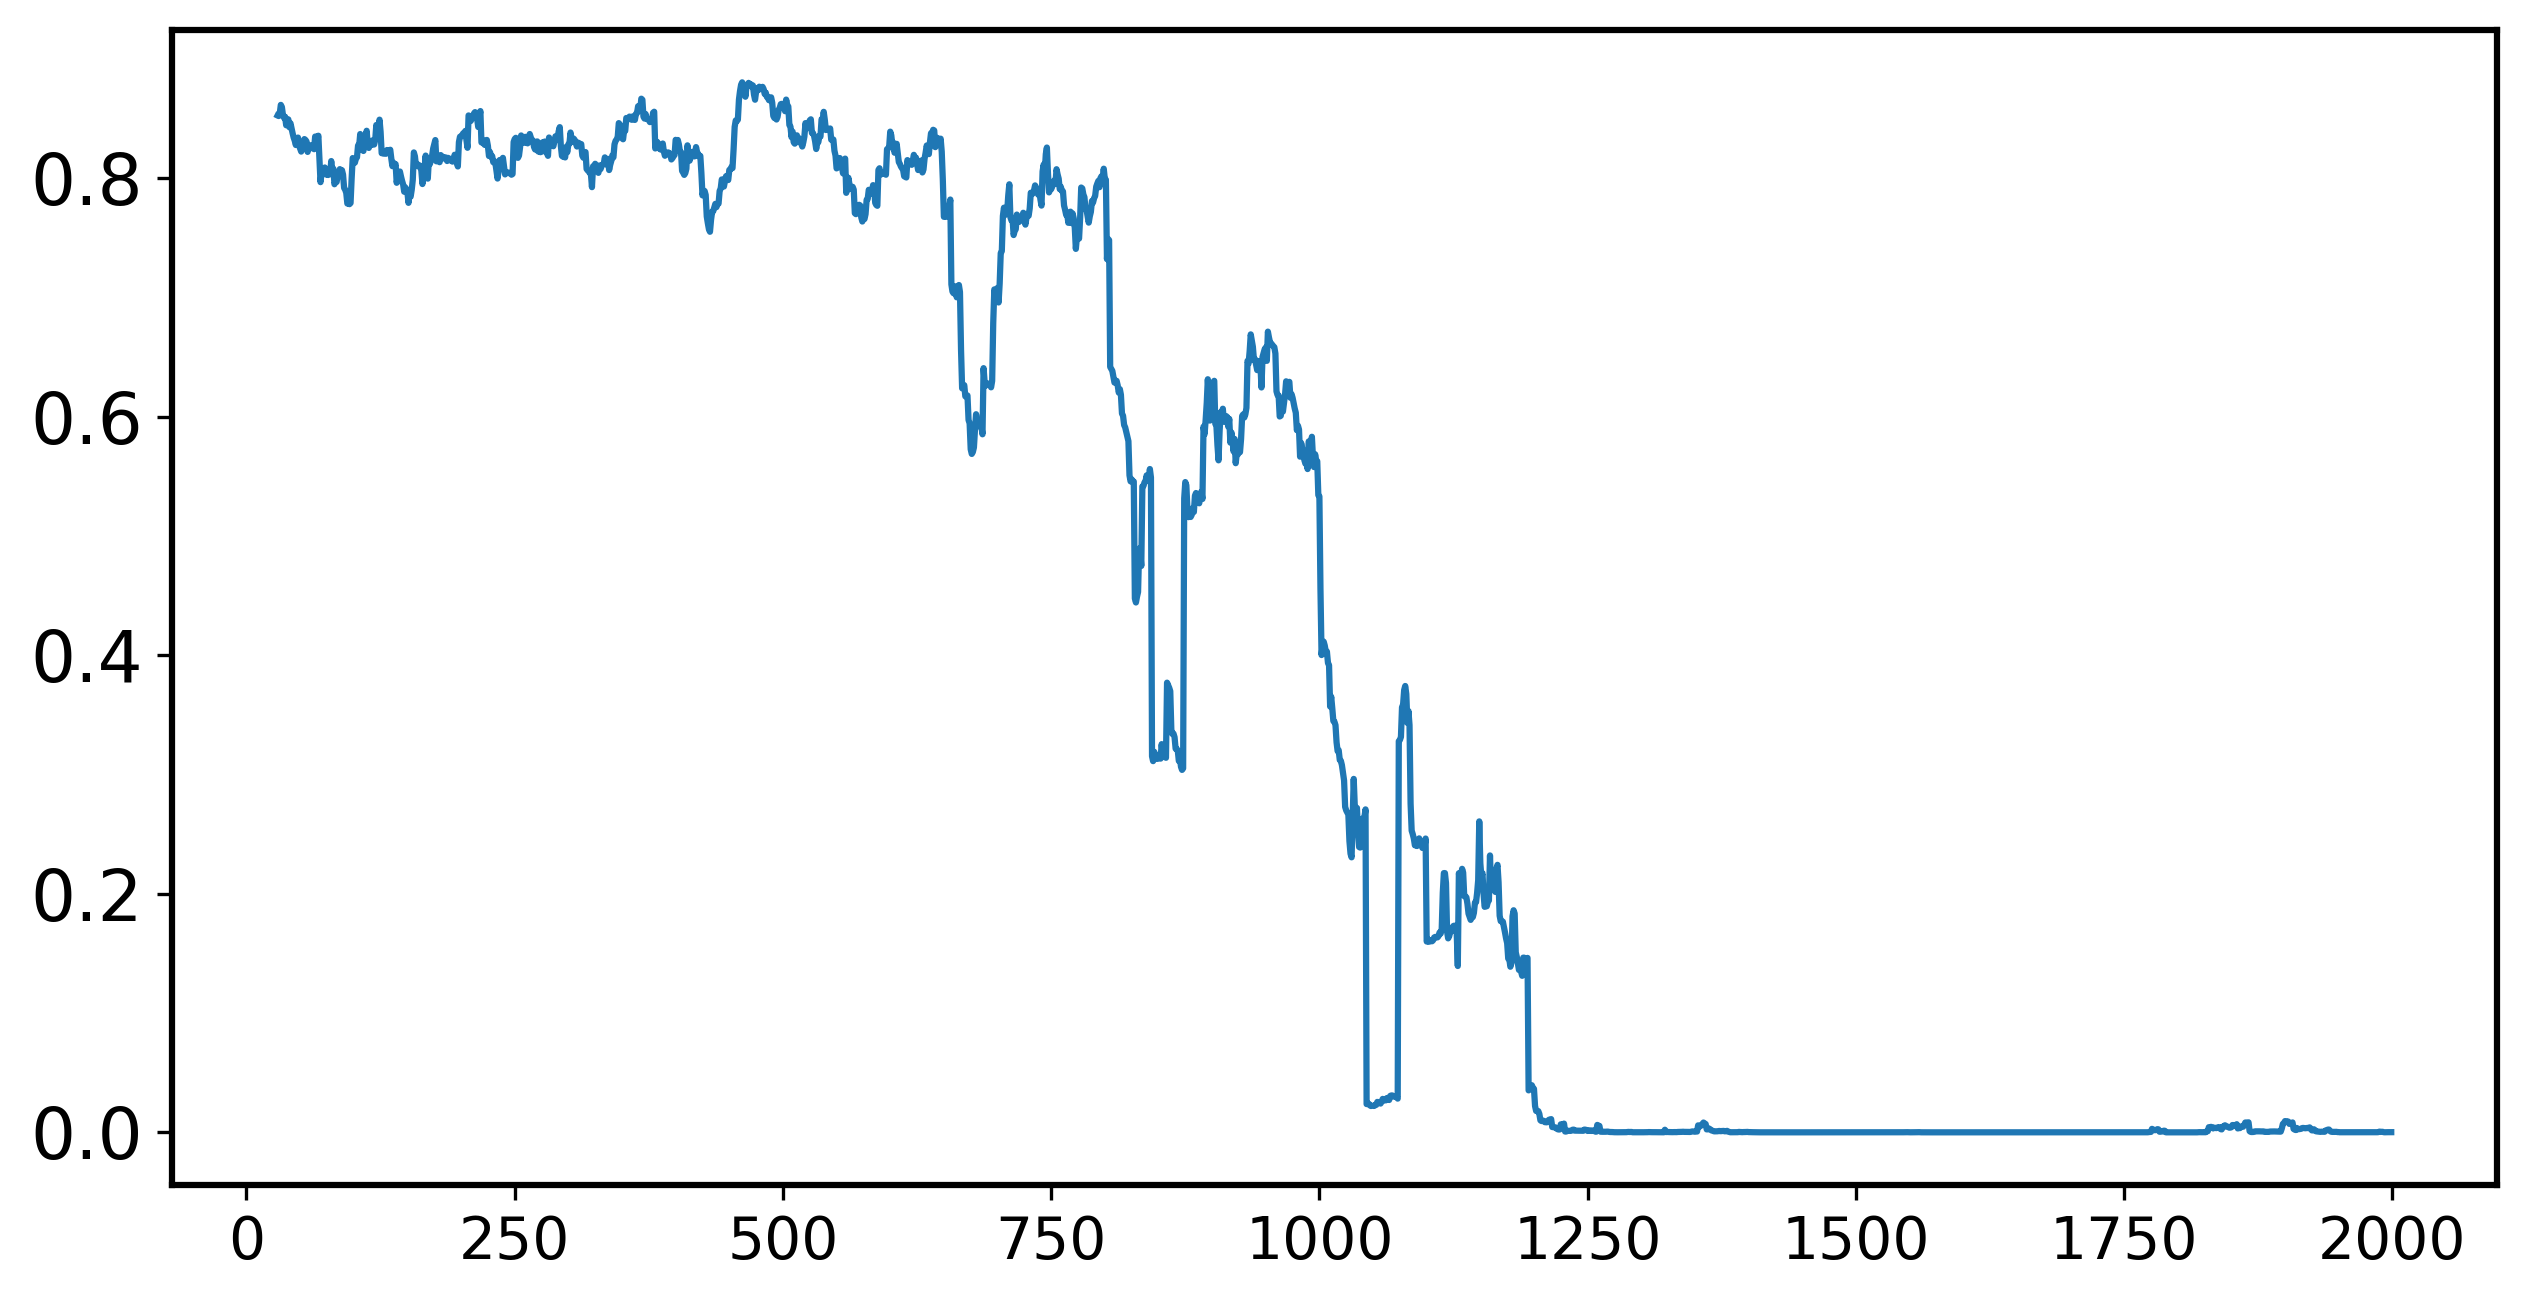

In [366]:
plt.figure(figsize=(10,5))
df_plot['gmm-score'].rolling(30).apply(lambda x: np.prod(x)).plot()